# Setup

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [10,6]

data = pd.read_csv('~/Documents/Github/data/train.csv')
val = pd.read_csv('~/Documents/Github/data/dev.csv')

# Naive Bayes on text
A quick way to mine the text information is by feeding it into a Naive Bayes model, which will learn which words and tfidf word combos tend to be associated with real vs. fake reviews. 

- Massive gains seen using the Tfidf-Vectorizer over the normal CountVectorizer
- Though not shown, no particular changes in performance seen swapping `n`-grams around

In [2]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr(pred, y, label, title=None):
    precision, recall, _ = precision_recall_curve(y, pred)
    aps = average_precision_score(y_true=y, y_score=pred)
    
    plt.step(recall, precision, alpha=0.2,
             where='post',
             label='{}: Average Precision = {:0.3f}'.format(label, aps))
    plt.fill_between(recall, precision, step='post', alpha=0.2)

    plt.xlabel('Recall', fontsize = 12)
    plt.ylabel('Precision', fontsize = 12)
    if title is None:
        title = 'Precision-Recall Curve'
    plt.title(title)
    plt.legend(loc="lower right")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB

cv = CountVectorizer(binary=False, ngram_range=(1,2), max_df=.5, min_df=.001)
text_data_train = cv.fit_transform(data['review'].tolist())
text_data_val = cv.transform(val['review'].tolist())

print(text_data_train.shape)
print(text_data_val.shape)

import scipy
text_data = scipy.sparse.vstack([text_data_train, text_data_val])

(250874, 17747)
(35918, 17747)


### Train set performance

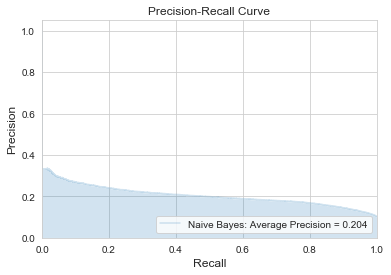

In [4]:
y = data['label']
nb = MultinomialNB()
nb.fit(text_data_train, y)

data['pred_nb'] = nb.predict_proba(text_data_train)[:,1]

plot_pr(data['pred_nb'], data['label'], label='Naive Bayes')

### Validation set performance

Text(0.5, 1.0, 'Naive Bayes with CV - Val Set Performance')

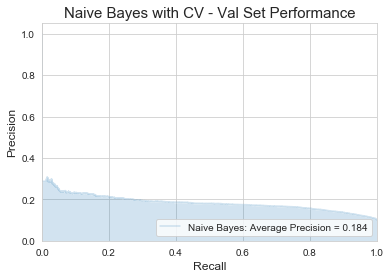

In [5]:
y = data['label']
nb = MultinomialNB()
nb.fit(text_data_train, y)

val['pred_nb'] = nb.predict_proba(text_data_val)[:,1]
plot_pr(val['pred_nb'], val['label'], label='Naive Bayes')
plt.title('Naive Bayes with CV - Val Set Performance', fontsize = 15)

## Large improvements using the `TfidfVectorizer`

In [6]:
cv = TfidfVectorizer(binary=False, ngram_range=(1,1), max_df=.5, min_df=.001)
text_data_train = cv.fit_transform(data['review'].tolist())
text_data_val = cv.transform(val['review'].tolist())

print(text_data_train.shape)
print(text_data_val.shape)

text_data = scipy.sparse.vstack([text_data_train, text_data_val])

(250874, 4701)
(35918, 4701)


### Train set performance

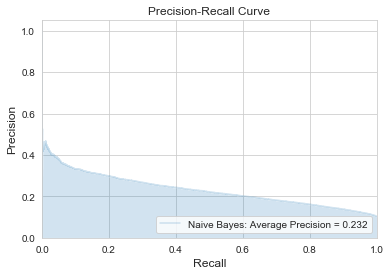

In [7]:
y = data['label']
nb = MultinomialNB()
nb.fit(text_data_train, y)

data['pred_nb'] = nb.predict_proba(text_data_train)[:,1]
plot_pr(data['pred_nb'], data['label'], label='Naive Bayes')

### Validation set performance

Text(0.5, 1.0, 'Naive Bayes with Tfidf - Val Set Performance')

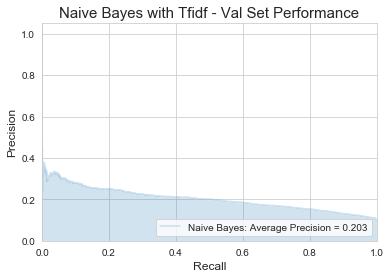

In [8]:
y = data['label']
nb = MultinomialNB()
nb.fit(text_data_train, y)

val['pred_nb'] = nb.predict_proba(text_data_val)[:,1]
plot_pr(val['pred_nb'], val['label'], label='Naive Bayes')
plt.title('Naive Bayes with Tfidf - Val Set Performance', fontsize = 15)

## Complement Naive Bayes

Text(0.5, 1.0, 'Complement Naive Bayes with Tf- - Val Set Performance')

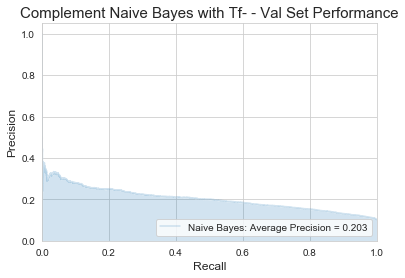

In [9]:
cnb = ComplementNB()
cnb.fit(text_data_train, y)

val['pred_nb'] = nb.predict_proba(text_data_val)[:,1]
plot_pr(val['pred_nb'], val['label'], label='Naive Bayes')
plt.title('Complement Naive Bayes with Tfidf - Val Set Performance', fontsize = 15)

## What are the largest magnitude Tfidf words for each document?
We might wonder which words see high tf-idf scores. If we leaf through the samples, we generally see that words relating to different cuisines, times, or sentiments tend to see high tf-idf scores. The lowest tfidf scores are extremely generic words. Very satisfying to observe!

In [10]:
vocab = pd.Series(cv.vocabulary_).reset_index().set_index(0)

In [11]:
def tfidf_scores(s, vocab, n=10, ascending=False):
    row_idx, col_idx, tfidf_value = scipy.sparse.find(s)
    words = vocab.loc[col_idx].copy()
    words['tfidf'] = tfidf_value
    words = words.sort_values('tfidf', ascending=ascending)[:n]
    return words['index'].tolist()

In [12]:
row_samples = np.random.randint(0, text_data.shape[0], 10)

print('Highest TFIDF')
for row in row_samples:
    print(tfidf_scores(text_data[row,:], vocab))
print('\n\n')
print('Lowest TFIDF')
for row in row_samples:
    print(tfidf_scores(text_data[row,:], vocab, ascending=True))

Highest TFIDF
['local', 'ingredients', 'fava', 'drink', 'dishes', 'strawberries', 'balsamic', 'state', 'eat', 'dined']
['always', 'exciting', 'rock', 'night', 'people', 'game', 'hipster', 'no', 'chill', 'weather']
['moroccan', 'couscous', 'north', 'definite', 'as', 'mediterranean', 'mint', 'polite', 'efficient', 'cuisine']
['too', 'killed', 'pizza', 'potential', 'sauce', 'much', 'dough', 'raw', 'soggy', 'oven']
['cool', 'need', 'flavor', 'nice', 'more', 'service', 'great', 'place', 'food']
['ratio', 'mediterranean', 'fare', 'eggplant', 'opinion', 'typical', 'falafel', 'street', 'egg', 'high']
['sushi', 'fishy', 'roll', 'spicy', 'tuna', 'we', 'never', 'ever', 'across', 'mouth']
['order', 'free', 'that', 'be', 'fries', 'employee', 'ready', 'heavily', '5pm', 'event']
['hero', 'tomorrow', 'draft', 'selections', 'hidden', 'meatball', 'thanks', '11', 'hole', 'delish']
['shops', 'baguette', 'california', 'difference', 'banh', 'vietnamese', 'mi', 'takes', 'does', 'as']



Lowest TFIDF
['my', '